### David P. Fleming, Jan. 2018

---

This notebook explores how to compute and estimate the KL Divergence.

In [1]:
%matplotlib inline

import scipy.stats as ss
import numpy as np
from approxposterior import utility as ut

import matplotlib as mpl
import matplotlib.pyplot as plt

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (9,8)
mpl.rcParams['font.size'] = 25.0

## for Palatino and other serif fonts use:
mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
mpl.rc('text', usetex=True)

### Compute KL Divergence for two normal distributions using scipy's entropy function

---

This method is quick and easy when you have 1D arrays representing the two pdfs.

In [2]:
# Normal distributions!
num = 1000
x = np.linspace(-5, 5, num)

# Make two different normal pdfs
p_diff = ss.norm.pdf(x, loc=1.2, scale=1)
q_diff = ss.norm.pdf(x, loc=-1.2, scale=1)

# Estimate KL divergence: Should be rather non-zero
kl_diff = ss.entropy(p_diff, q_diff)
print(kl_diff)

2.87931253029


In [3]:
# Make two slightly different normal pdfs
p_close = ss.norm.pdf(x, loc=0, scale=1)
q_close = ss.norm.pdf(x, loc=0.2, scale=0.8)

# Estimate KL divergence: should be close to zero
kl_close = ss.entropy(p_close, q_close)
print(kl_close)

0.0893529245286


In [4]:
# Use the same pdf now
p = ss.norm.pdf(x, loc=0, scale=1)

# Estimate KL divergence: should be zero
kl_same = ss.entropy(p,p)
print(kl_same)

0.0


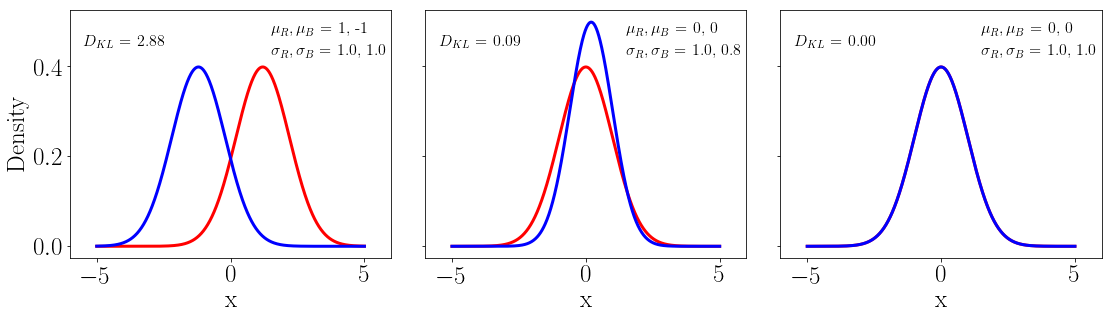

In [5]:
# Plot the distributions and the KL divergence!
fig, axes = plt.subplots(ncols=3, figsize=(16,5), sharey=True)

# Listify the quantities
ps = [p_diff, p_close, p]
qs = [q_diff, q_close, p]
kls = [kl_diff, kl_close, kl_same]
mus = [[1.2,-1.2], [0,0.2], [0,0]]
sigs = [[1,1], [1,0.8], [1,1]]

# Plot the data with annotations
for ii in range(len(axes)):
    axes[ii].plot(x, ps[ii], 'r-', lw=3)
    axes[ii].plot(x, qs[ii], 'b-', lw=3)

    # Add KL Divergence
    axes[ii].text(-5.5, 0.45, "$D_{KL}$ = %.2lf" % kls[ii],
              ha="left", va="center", size=16, color="k",
              bbox=dict(boxstyle="square", fc="w", ec="none"))

    # Add Gaussian Parameters
    axes[ii].text(1.5, 0.48, "$\mu_R, \mu_B$ = %.0lf, %.0lf" % (mus[ii][0],mus[ii][1]),
              ha="left", va="center", size=16, color="k",
              bbox=dict(boxstyle="square", fc="w", ec="none"))
    axes[ii].text(1.5, 0.43, "$\sigma_R, \sigma_B$ = %.1lf, %.1lf" % (sigs[ii][0],sigs[ii][1]),
              ha="left", va="center", size=16, color="k",
              bbox=dict(boxstyle="square", fc="w", ec="none"))

# Format all axes
axes[0].set_ylabel("Density")
for ax in axes:
    ax.set_xlabel("x")
    
    ax.set_ylim(-0.025,0.525)
    ax.set_xlim(-6,6)
fig.tight_layout()

### Numerically estimate the KL divergence via samping the distributions

---

When you have a weird, multi-dimensional pdf, you must turn to numerical methods to get an answer.

Here, we examine the 1st case (left panel of the above figure) to see gauge the performance of our numerical method of estimating the KL divergence. 

In [6]:
# Example usage:
p_kwargs = {"loc": 1, "scale": 1}
q_kwargs = {"loc" : -1, "scale" : 1}

# Wrap the functions
p_pdf = ut.function_wrapper(ss.norm.pdf, **p_kwargs)
q_pdf = ut.function_wrapper(ss.norm.pdf, **q_kwargs)

In [8]:
# How does it all scale as a function of the number of random samples?
nums = [100, 1000, 10000, 100000]
seeds = [42,1,55,91]
iters = 5

error = np.zeros((len(nums), iters))

p_kwargs = {"loc": 1.2, "scale": 1}
q_kwargs = {"loc" : -1.2, "scale" : 1}

# Wrap the functions
p_pdf = ut.function_wrapper(ss.norm.pdf, **p_kwargs)
q_pdf = ut.function_wrapper(ss.norm.pdf, **q_kwargs)

for ii in range(len(nums)):
    # Reset seed for "new" random numbers
    np.random.seed(seeds[ii])
    for jj in range(iters):
        x = ss.norm.rvs(loc=1.2, scale=1, size=nums[ii])
        error[ii,jj] = ut.kl_numerical(x, p_pdf, q_pdf)
        
# Compute mean, error of KL divergence numerical estimates
means = np.mean(error, axis=1)
stds = np.std(error, axis=1)

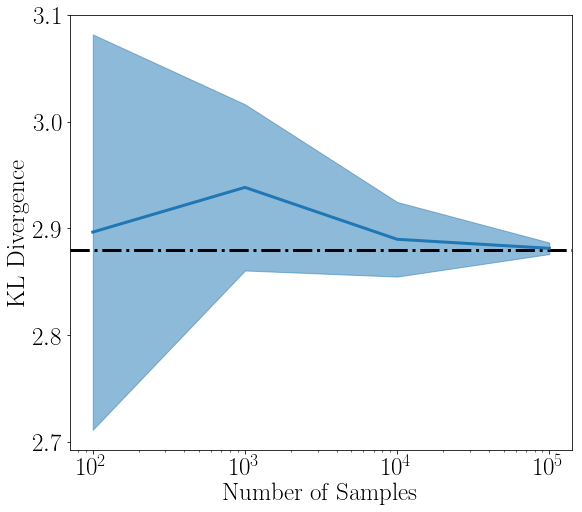

In [10]:
# Plot it!
fig, ax = plt.subplots()

# Truth
ax.axhline(kl_diff, ls="-.", lw=3, color="k")

# Estimate, error envelope at each step
ax.plot(nums, means, lw=3, color="C0")
ax.fill_between(nums, means - stds, means + stds, alpha=0.5, color="C0")

ax.set_ylabel("KL Divergence")

ax.set_xlabel("Number of Samples")
ax.set_xscale("log")